In [1]:
#importing necessary libraries
# General

import numpy as np
import pandas as pd
import re
import os
import pickle

# EDA

import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter

# NLP 

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize 

# ML
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df=pd.read_csv('spam.csv',encoding = 'latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<AxesSubplot: >

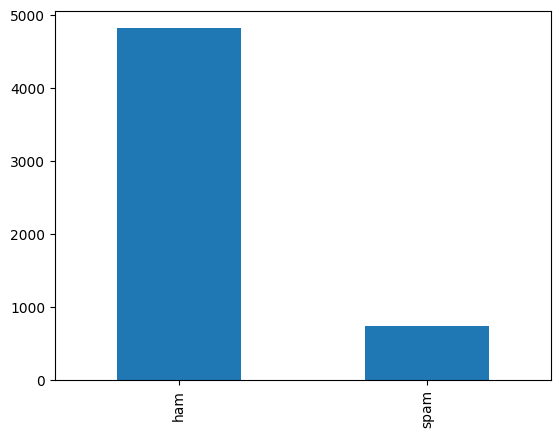

In [3]:
df['v1'].value_counts(dropna=False).plot(kind='bar')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [6]:
#checking for null values
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [7]:
#dropping the column with more null values
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [8]:
#renaming the columns
df=df.rename({'v1':'label','v2':'text'},axis=1)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Calculating the length of each data sample
We will create a new length column that will show the length of each data sample. This new column will help us with preprocessing the data samples.

In [9]:
df['length'] = df['text'].apply(lambda x: len(x))

In [10]:
df.head()

,label,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Distribution based on length of words



In [11]:
#analyzing text
df['length']=df['text'].apply(lambda x: len(x))

C:\Users\rusla\AppData\Local\Temp\ipykernel_31156\56211616.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['length'], kde=True)


<AxesSubplot: xlabel='length', ylabel='Density'>

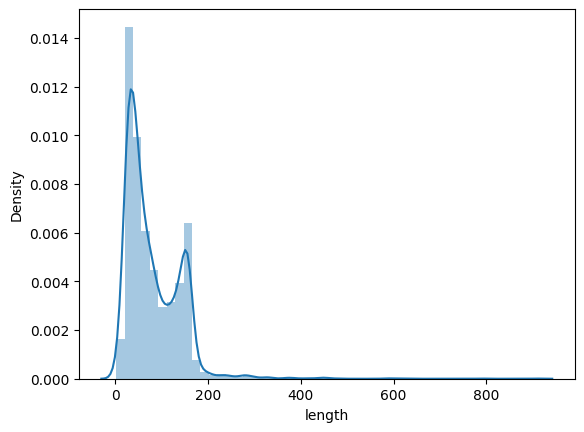

In [12]:
sns.distplot(df['length'], kde=True)

<AxesSubplot: xlabel='label', ylabel='length'>

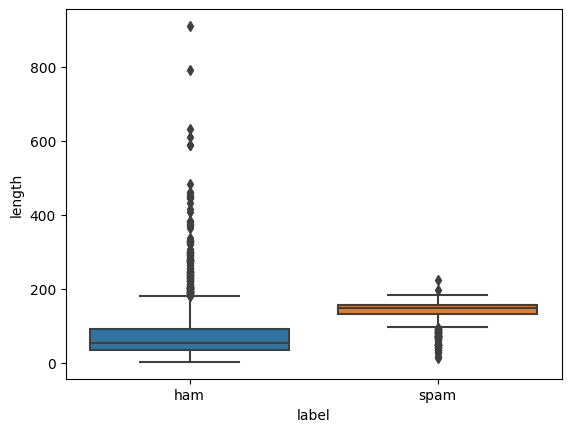

In [13]:
sns.boxplot(y='length', x='label', data=df)

In [14]:
df.head()

,label,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## Data Preprocessing

NLTK has smaller sub-libraries that perform specific text cleaning tasks. These smaller libraries also have methods for text cleaning.

In [15]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rusla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Downloading stop words
We download the English stop words so that the model can identify the stop words in the texts and remove them.

In [16]:
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rusla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rusla\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

We will use it to remove all the stop words in the dataset. We will then create custom functions for text cleaning and pass in the imported methods as parameters. To implement the custom functions, we will require Python regular expression (RegEx) module.

In [17]:
def convert_to_lower(text):
    return text.lower()
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

import string
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)



In [18]:
df['text_clean'] = df['text'].apply(lambda x: convert_to_lower(x))

In [19]:
df['text_clean'] = df['text_clean'].apply(lambda x: remove_numbers(x))

In [20]:
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punctuation(x))

In [21]:
df['text_clean'] = df['text_clean'].apply(lambda x: remove_stopwords(x))

In [22]:
df['text_clean'] = df['text_clean'].apply(lambda x: remove_extra_white_spaces(x))

In [23]:
df['text_clean'] = df['text_clean'].apply(lambda x: lemmatizing(x))

In [24]:
df['length_after_cleaning'] = df['text_clean'].apply(lambda x: len(x))


In [25]:
df.head()

,label,text,length,text_clean,length_after_cleaning
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis great wo...,78
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif oni,21
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...,101
3,ham,U dun say so early hor... U c already then say...,49,u dun say early hor c already say,33
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah dont think go usf life around though,40


In [26]:
def get_corpus(df):
    corpus = []
    ps = PorterStemmer()
    for i in range(len(df)):
        msg = re.sub('[^a-zA-Z]', ' ', df['text'][i]) #removing non alphabetics
        msg = msg.lower()#lowering the case
        msg = msg.split()
        msg = [ps.stem(word) for word in msg if not word in stopwords.words('english')] # Stemming & Stopwords Removal
        msg = ' '.join(msg)
        corpus.append(msg)
    return corpus

In [27]:
corpus=get_corpus(df)

In [28]:
#adding new column
df['corpus'] = corpus
df.head()

,label,text,length,text_clean,length_after_cleaning,corpus
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis great wo...,78,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif oni,21,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...,101,free entri wkli comp win fa cup final tkt st m...
3,ham,U dun say so early hor... U c already then say...,49,u dun say early hor c already say,33,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah dont think go usf life around though,40,nah think goe usf live around though


In [29]:
wordcloud =False
if wordcloud:
    plt.figure(figsize = (24, 6))
    wc = WordCloud(min_font_size = 10, background_color = 'lightblue')
    spam_wc = wc.generate(df[df['label'] == 'spam']['corpus'].str.cat(sep = " "))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(spam_wc)
    
    plt.figure(figsize = (24, 6))
    wc = WordCloud(min_font_size = 10, background_color = 'lightblue')
    ham_wc = wc.generate(df[df['label'] == 'ham']['corpus'].str.cat(sep = " "))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(ham_wc);


In [31]:
#transform the values of the output variable into 0 and 1
#We can create the label map as follows:
label_map = {
    'ham': 0,
    'spam': 1,
}
df['label'] = df['label'].map(label_map)

## Implementing text vectorization
It converts the raw text into a format the NLP model can understand and use. Vectorization will create a numerical representation of the text strings called a sparse matrix or word vectors. The model works with numbers and not raw text. We will use TfidfVectorizer to create the sparse matrix.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
tf_wb= TfidfVectorizer()
X_tf = tf_wb.fit_transform(df['text_clean'])
#Converting the sparse matrix into an array
#We then apply the toarray function to convert the sparse matrix into an array.
X_tf = X_tf.toarray()

In [33]:
X_tf.shape
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, df['label'].values, test_size=0.3)
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train_tf, y_train_tf)
NB_pred= NB.predict(X_test_tf)
print(NB_pred)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_tf, NB_pred))

[0 0 0 ... 0 0 0]
0.8767942583732058


In [34]:
from imblearn.over_sampling import RandomOverSampler

We will use the RandomOverSampler function to balance the classes.

RandomOverSampler will increase the data samples in the minority class (spam). It makes the minority class have the same data samples as the majority class (ham). The function synthesizes new dummy data samples in the minority class to enable class balancing.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['text_clean'], df['label'].values, test_size=0.30)

After splitting the dataset, we will use the Counter module to check the number of data samples in the majority and minority classes. We import the module as follows:

In [36]:
from collections import Counter

In [37]:
Counter(y_train)

Counter({0: 3391, 1: 509})

In [38]:
#Vectorizing the X_train
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer()

The fit function will fit the initialized TfidfVectorizer function to the X_train. We then use the transform function to apply the vectorization method.

In [39]:
X_train_tf = vectorizer.transform(X_train)

We finally convert the transformed text (sparse matrix) to an array as follows:



In [40]:
X_train_tf = X_train_tf.toarray()

In [41]:
#Vectorizing the X_test
X_test_tf = vectorizer.transform(X_test)
X_test_tf = X_test_tf.toarray()

Let’s now apply the RandomOverSampler function.

Applying RandomOverSampler function
We use the following code:

In [42]:
ROS = RandomOverSampler(sampling_strategy=1)

The function uses the sampling_strategy parameter to balance the class. We set the parameter’s value to 1 to ensure the dataset classes have 1:1 data samples. We then apply the function to the training set. It will generate the new data samples to ensure both classes are balance

In [43]:
X_train_ros, y_train_ros = ROS.fit_resample(X_train_tf, y_train)

Let’s recheck the number of data samples in the majority and minority classes:

In [44]:
Counter(y_train_ros)

Counter({0: 3391, 1: 3391})

Using the balanced dataset to build the same model

In [45]:
nb = GaussianNB()
nb.fit(X_train_ros, y_train_ros)
y_preds = nb.predict(X_test_tf)
print(y_preds)

[0 0 1 ... 0 0 0]


In [46]:
print(accuracy_score(y_test, y_preds))

0.8851674641148325


Actually NLP is one of the most common areas in which resampling of data is needed as there are many text classification tasks dealing with imbalanced problem (think of spam filtering, insulting comment detection, article classification, etc.

# Oversampling

In [47]:
X_tf.shape

(5572, 7858)

In [48]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE , ADASYN,SVMSMOTE,KMeansSMOTE,BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

In [49]:
def run_model(X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    print(Counter(y_train))
    vectorizer_smote = TfidfVectorizer()
    vectorizer_smote.fit(X_train)
    #Vectorizing the X_train
    X_train_vec = vectorizer_smote.transform(X_train)
    X_train_vec = X_train_vec.toarray()
    #Vectorizing the X_test
    X_test_vec = vectorizer_smote.transform(X_test)
    X_test_vec = X_test_vec.toarray()
    # transform the dataset
    oversample = model
    X_train_over, y_train_over = oversample.fit_resample(X_train_vec, y_train)
    print(Counter(y_train_over))
    nb = GaussianNB()
    nb.fit(X_train_over, y_train_over)
    y_preds = nb.predict(X_test_vec)
    score = accuracy_score(y_test,y_preds)
    print("Accuracy: ",score)
    #target_names = ['class 0', 'class 1'] 
    #print(classification_report_imbalanced(y_test, y_preds,     target_names=target_names))
    return score

In [50]:
X=df['text_clean']
y=df['label'].values

In [51]:
#Object to over-sample the minority class(es) by picking samples at random with replacement. 
oversample= RandomOverSampler(sampling_strategy=1)
ov1=run_model(X,y,model=oversample)

Counter({0: 3353, 1: 547})
Counter({0: 3353, 1: 3353})
Accuracy:  0.8839712918660287


In [52]:
# over-sampling using SMOTE.
oversample=SMOTE(sampling_strategy=0.2)
ov2=run_model(X,y,model=oversample)

Counter({0: 3389, 1: 511})
Counter({0: 3389, 1: 677})
Accuracy:  0.882177033492823


In [53]:
#Oversample using Adaptive Synthetic (ADASYN) algorithm.
oversample = ADASYN()
ov3=run_model(X,y,model=oversample)

Counter({0: 3375, 1: 525})
Counter({1: 3399, 0: 3375})
Accuracy:  0.8708133971291866


In [54]:
#KMeans clustering before to over-sample using SMOTE.
oversample=KMeansSMOTE()
ov4=run_model(X,y,model=oversample)

Counter({0: 3391, 1: 509})
Counter({1: 3391, 0: 3391})
Accuracy:  0.8929425837320574


In [55]:
#Over-sampling using Borderline SMOTE
oversample=BorderlineSMOTE()
ov5=run_model(X,y,model=oversample)

Counter({0: 3376, 1: 524})
Counter({0: 3376, 1: 3376})
Accuracy:  0.8803827751196173


In [56]:
#Over-sampling using SMOTE and cleaning using ENN.
oversample=SMOTEENN()
ov6=run_model(X,y,model=oversample)

Counter({0: 3376, 1: 524})
Counter({0: 3361, 1: 3352})
Accuracy:  0.8738038277511961


In [57]:
#Over-sampling using SVM-SMOTE.
oversample=SVMSMOTE()
ov7=run_model(X,y,model=oversample)

Counter({0: 3391, 1: 509})
Counter({0: 3391, 1: 3391})
Accuracy:  0.882177033492823


,Model,Accuracy_score
3,KMeans-SMOTE,0.892943
0,RandomOverSampler,0.883971
1,SMOTE,0.882177
4,Borderline-SMOTE,0.880383
5,SMOTE-ENN,0.873804
2,ADASYN,0.870813


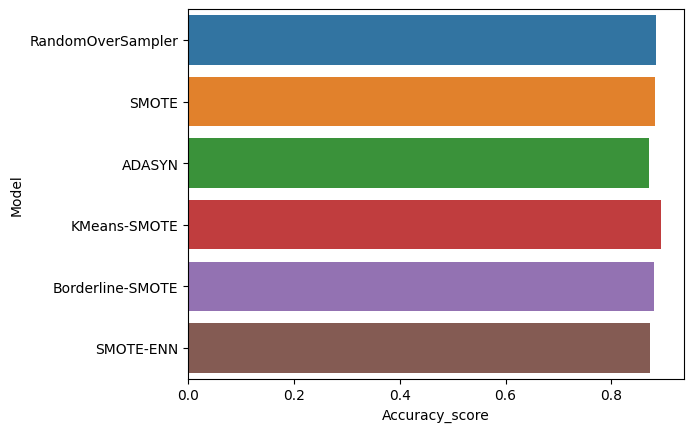

In [58]:
over_models = pd.DataFrame({
    'Model':['RandomOverSampler',
             'SMOTE',
             'ADASYN',
             'KMeans-SMOTE',
             'Borderline-SMOTE',
             'SMOTE-ENN'
            ],
    'Accuracy_score' :[ov1 ,ov2, ov3, ov4,ov5,ov6
                      ]
})
sns.barplot(x='Accuracy_score', y='Model', data=over_models)
over_models.sort_values(by='Accuracy_score', ascending=False)

# Downsampling

In [59]:
from imblearn.under_sampling  import RandomUnderSampler,AllKNN,NearMiss, TomekLinks

In [60]:
# random under-sampling
undersample=RandomUnderSampler()
un1=run_model(X,y,model=undersample)

Counter({0: 3393, 1: 507})
Counter({0: 507, 1: 507})
Accuracy:  0.8331339712918661


In [61]:
# Undersample based on the AllKNN method.
undersample=AllKNN()
un2=run_model(X,y,model=undersample)

Counter({0: 3373, 1: 527})
Counter({0: 3370, 1: 527})
Accuracy:  0.8779904306220095


In [62]:
# under-sampling based on NearMiss methods.
# NearMiss-1: Majority class examples with minimum average distance to three closest minority class examples.
undersample=NearMiss(version=1)
un3=run_model(X,y,model=undersample)

Counter({0: 3395, 1: 505})
Counter({0: 505, 1: 505})
Accuracy:  0.8462918660287081


In [63]:
#Under-sampling by removing Tomek's links.
undersample=TomekLinks()
un4=run_model(X,y,model=undersample)

Counter({0: 3385, 1: 515})
Counter({0: 3383, 1: 515})
Accuracy:  0.8845693779904307


,Model,Accuracy_score
3,Tomek,0.884569
1,AllKNN,0.877990
2,NearMiss,0.846292
0,RandomUnderSampler,0.833134


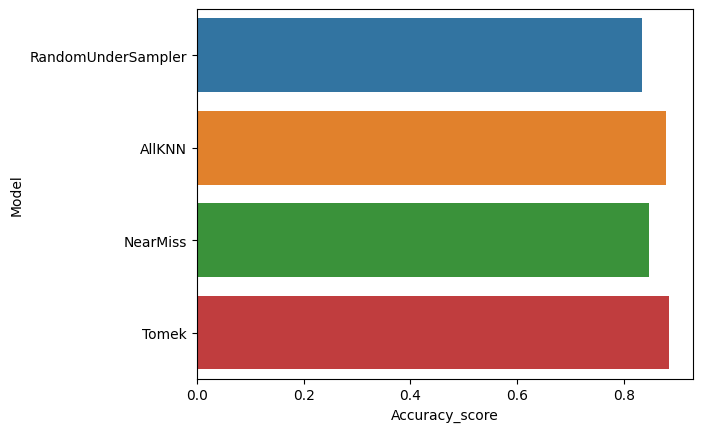

In [64]:
under_models = pd.DataFrame({
    'Model':['RandomUnderSampler',
             'AllKNN',
             'NearMiss',
             'Tomek'
            ],
    'Accuracy_score' :[un1 ,un2, un3, un4,
                      ]
})
sns.barplot(x='Accuracy_score', y='Model', data=under_models)
under_models.sort_values(by='Accuracy_score', ascending=False)

# Pipeline

TF-IDF - normalizing and weighting with diminishing importance tokens that occur in the majority of documents.

1.TF(Term frequency)-Term frequency works by looking at the frequency of a particular term you are concerned with relative to the document. There are multiple measures, or ways, of defining frequency

2.IDF (inverse document frequency)-Inverse document frequency looks at how common (or uncommon) a word is amongst the corpus.

The output above shows the label column has the assigned integer values (0 and 1). The next step is to implement text vectorization.

We will split the vectorized dataset into two portions/sets. The first portion will be for model training and the second portion for model testing. We will use the train_test_split method to split the vectorized dataset.

In [65]:
#split the data into train and test sets
X=df['text_clean']
y=df['label']
#y=df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [66]:
def model(model_name,X_train,y_train,X_test,y_test):
    pipeline=Pipeline([
    ('tfidf', TfidfVectorizer()),#transform the texts into the vectorized input variables X
    ('model', model_name),
    ])
    pipeline.fit(X_train,y_train)

    preds=pipeline.predict(X_test)

    print (classification_report(y_test,preds))
    print (confusion_matrix(y_test,preds))
    print('Accuracy:', pipeline.score(X_test, y_test)*100)
    print("Training Score:",pipeline.score(X_train,y_train)*100)
    from sklearn.metrics import accuracy_score
    score = accuracy_score(y_test,preds)
    return score

MultinomialNB

In [67]:
mnb=model(MultinomialNB(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.85       150

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115

[[965   0]
 [ 38 112]]
Accuracy: 96.59192825112108
Training Score: 97.55440879515369


RF


In [68]:
rf=model(RandomForestClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[965   0]
 [ 25 125]]
Accuracy: 97.75784753363229
Training Score: 100.0


XGBoost

In [69]:
xgb=model(XGBClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       0.97      0.82      0.89       150

    accuracy                           0.97      1115
   macro avg       0.97      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

[[961   4]
 [ 27 123]]
Accuracy: 97.21973094170404
Training Score: 98.99035225487997


SVM

In [70]:
svc=model(SVC(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       0.98      0.83      0.90       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.94      1115
weighted avg       0.98      0.98      0.97      1115

[[963   2]
 [ 25 125]]
Accuracy: 97.57847533632287
Training Score: 99.73076060130133


Model Comparison

,Model,Accuracy_score
1,RF,0.977578
3,SVM,0.975785
2,XGBoost,0.972197
0,MNB,0.965919


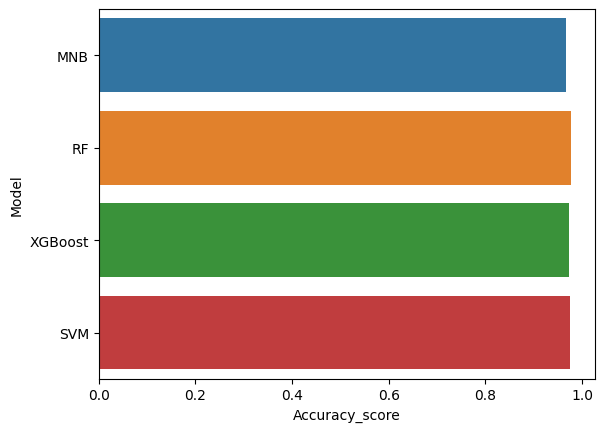

In [71]:
models = pd.DataFrame({
    'Model':['MNB','RF','XGBoost', 'SVM'],
    'Accuracy_score' :[mnb ,rf, xgb, svc]
})
sns.barplot(x='Accuracy_score', y='Model', data=models)
models.sort_values(by='Accuracy_score', ascending=False)

# Final model

In [72]:
def run_model_sampling(X,y,mlmodel,sampling=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    print(Counter(y_train))
    vectorizer_smote = TfidfVectorizer()
    vectorizer_smote.fit(X_train)
    #Vectorizing the X_train
    X_train_vec = vectorizer_smote.transform(X_train)
    X_train_vec = X_train_vec.toarray()
    #Vectorizing the X_test
    X_test_vec = vectorizer_smote.transform(X_test)
    X_test_vec = X_test_vec.toarray()
    # transform the dataset ( Sampling model)
    oversample = sampling
    if oversample: 
        X_train_over, y_train_over = oversample.fit_resample(X_train_vec, y_train)
        X_train_vec= X_train_over 
        y_train = y_train_over        
    print(Counter(y_train))
    # Machine Learning Model
    model=mlmodel
    model.fit(X_train_vec, y_train)
    y_preds = model.predict(X_test_vec)
    score = accuracy_score(y_test,y_preds)
    print("Accuracy: ",score)
    target_names = ['class 0', 'class 1'] 
    print(classification_report_imbalanced(y_test, y_preds, target_names=target_names))
    return score

In [73]:
X=df['text_clean']
y=df['label'].values
mlmodel=RandomForestClassifier()
sampling=KMeansSMOTE()
run_model_sampling(X,y,mlmodel,sampling)

Counter({0: 3364, 1: 536})
Counter({0: 3364, 1: 3364})
Accuracy:  0.9736842105263158
                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.97      1.00      0.79      0.99      0.89      0.81      1461
    class 1       1.00      0.79      1.00      0.88      0.89      0.77       211

avg / total       0.97      0.97      0.82      0.97      0.89      0.80      1672



0.9736842105263158

In [74]:
X=df['text_clean']
y=df['label'].values
mlmodel=RandomForestClassifier()
run_model_sampling(X,y,mlmodel)

Counter({0: 3390, 1: 510})
Counter({0: 3390, 1: 510})
Accuracy:  0.9766746411483254
                   pre       rec       spe        f1       geo       iba       sup

    class 0       0.97      1.00      0.84      0.99      0.91      0.85      1435
    class 1       1.00      0.84      1.00      0.91      0.91      0.82       237

avg / total       0.98      0.98      0.86      0.98      0.91      0.85      1672



0.9766746411483254

In [75]:
import IPython
#from IPython.lib import kernel
from ipykernel.kernelbase import Kernel


In [76]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [77]:
import os
command_convert="jupyter nbconvert "
command_in=theNotebook+".ipynb"
command_out=theNotebook+".md"
command_action=" --to markdown --output "
command=command_convert+command_in+command_action+command_out
print(command)
os.system(command)

jupyter nbconvert nlp.ipynb --to markdown --output nlp.md


0